# Time series forecasting

### What is time series forecasting?
We will use time data to forecast (predict) upcoming COVID-19 cases for the Skåne region in Sweden.

### **Dataset**
Number of COVID-19 cases in Sweden per day and region. The dataset is from [Sveriges dataportal](https://www.dataportal.se/sv) and can be found [here](https://www.dataportal.se/sv/datasets/525_1424/antal-fall-av-covid-19-i-sverige-per-dag-och-region).

### What time frames are we looking at?
* Short term: Week
* Medium term: Few months
* Long term: Yearss


In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [176]:
# Import data
data = 'covid-cases.csv'
df = pd.read_csv(data)

# Lock Skåne column
skåne = df.iloc[:, 12:13]

# Lock date column
datum = df.iloc[:, -1:]

# Merge dataframes
df_covid = pd.merge(skåne, datum, left_index=True, right_index=True)
df_covid.head()

,Skåne,Statistikdatum
0,758,30/11/2020
1,355,29/11/2020
2,373,28/11/2020
3,1374,27/11/2020
4,685,26/11/2020


In [177]:
# Rename column Statistikdatum to Datum
df_covid.rename(columns={'Statistikdatum': 'Datum'}, inplace=True)

In [178]:
# Check type of datum
print("Datum data type: ", type(df_covid['Datum'][0]))

# Convert column Datum from string to datetime
df_covid['Datum'] = pd.to_datetime(df_covid['Datum'], infer_datetime_format=True)

# Check type of datum
print("Datum data type after converting: ", type(df_covid['Datum'][0]))

Datum data type:  <class 'str'>
Datum data type after converting:  <class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [179]:
# Set date as the index of the dataframe
df_covid = df_covid.set_index(['Datum'])

In [180]:
df_covid.head()

,Skåne
Datum,
2020-11-30,758
2020-11-29,355
2020-11-28,373
2020-11-27,1374
2020-11-26,685


# Visualization and data exploration

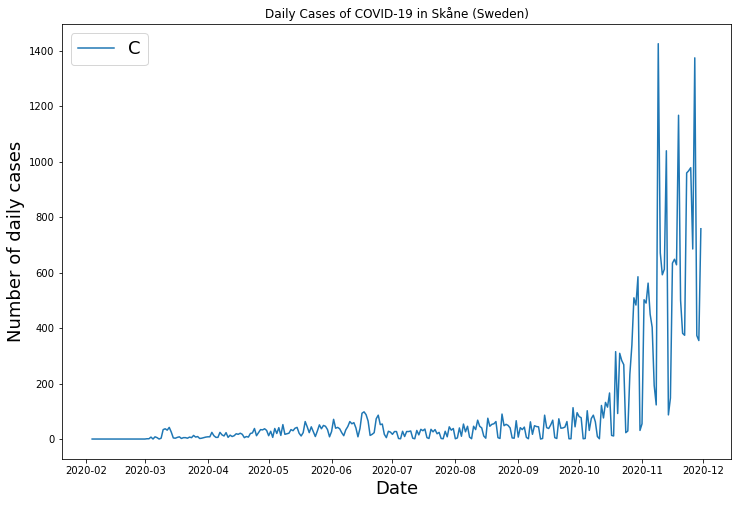

In [181]:
plt.figure(figsize=(12,8))
plt.plot(df_covid)
plt.title('Daily Cases of COVID-19 in Skåne (Sweden)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Number of daily cases', fontsize=18)
plt.legend('C', fontsize=18);

## Cumulative sums
The total sum of data as it grows with time.

In [182]:
# We need to reverse the dataframe to get the total sum counting from the first case
reversed_df = df_covid.iloc[::-1]

In [183]:
# Save as a new dataframe
covid_cumulative = np.cumsum(reversed_df)

In [184]:
# Last entries
covid_cumulative.tail()

,Skåne
Datum,
2020-11-26,25888
2020-11-27,27262
2020-11-28,27635
2020-11-29,27990
2020-11-30,28748


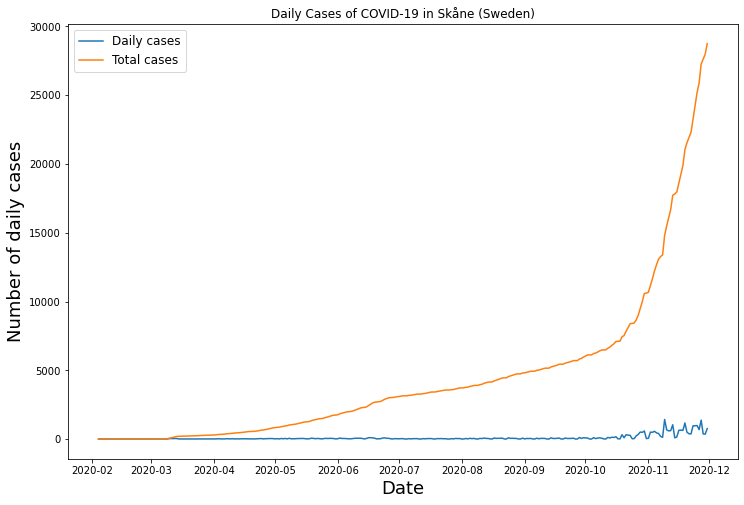

In [185]:
# Plot time series with cumulative
plt.figure(figsize=(12,8))
plt.plot(df_covid)
plt.plot(covid_cumulative)
plt.title('Daily Cases of COVID-19 in Skåne (Sweden)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Number of daily cases', fontsize=18)
plt.legend(['Daily cases', 'Total cases'], fontsize=12);

# Stationary vs non-stationary
* **Seasonality**: Variations that occur at specific regular intervals 
* **Trend**: Tendency of the data to increase or decrease during a longer period of time
* **Stationary**: No trends or seasonality, easier to model around
* **Non-stationary**: If there is seasonality or a trend to the time series it is non-stationary.
<br><br>
Let us test the dataset for stationarity.

## The Augmented Dickey-Fuller test 
* Statistical test called a unit root test
* Determines how strongly a time series is defined by a trend
* The p-value should be less than the significance level (say 0.05) in order for the time series to be stationary.

In [186]:
from statsmodels.tsa.stattools import adfuller

def stationarity_test(df):
    
    result=adfuller(df)
    output = pd.Series(result[0:1], index=['P-value'])
    
    if result[1] <= 0.05:
        print('---Dataset is stationary---')
        print(output)
        
    elif result[1] >= 0.05:
        print('---Dataset is non-stationary---')
        print(output)
    
    

In [187]:
stationarity_test(df_covid)

---Dataset is stationary---
P-value   -3.913886
dtype: float64


Our data is stationary and we can move on with out data exploration.

## Autocorrelation
* Similarity between observations as a function of the time
* Correlation within the data on a time scale
<br><br>

We will test for autocorrelation in our data. <br>
If the plots are outside of the blue area it shows correlation in the data.

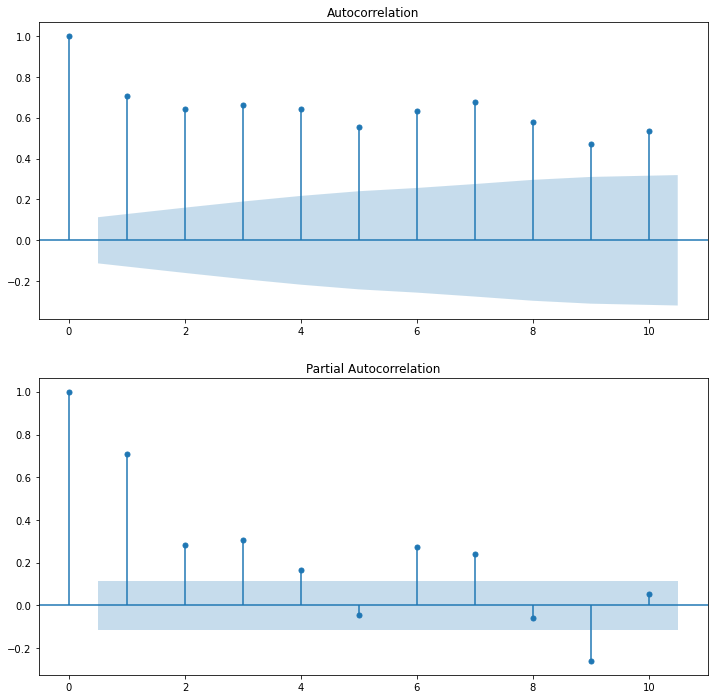

In [188]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

plot_acf(df_covid, lags=10, ax=ax1)
plot_pacf(df_covid, lags=10, ax=ax2);

## ARIMA Model

In [194]:
# Install pmdarima
#pip install pmdarima


ImportError: cannot import name 'iterkeys' from 'statsmodels.compat.python' (C:\Users\Helena\Anaconda3\envs\pysyft\lib\site-packages\statsmodels\compat\python.py)

In [193]:
import pmdarima as pmd

def arimamodel(timeseriesarray):
    autoarima_model = pmd.auto_arima(timeseriesarray, 
                              start_p=1, 
                              start_q=1,
                              test="adf",
                              trace=True)
    return autoarima_model

ImportError: cannot import name 'iterkeys' from 'statsmodels.compat.python' (C:\Users\Helena\Anaconda3\envs\pysyft\lib\site-packages\statsmodels\compat\python.py)

# Evaluation